In [1]:
#Fáza 3 - Strojové učenie, Tomáš Rafaj, Anna Yuová Dataset č. 28 Percentuálny podiel práce: 50/50

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
from numpy.random import seed 
from numpy.random import randn 
from numpy import mean
from numpy import std
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [2]:
# Bod 1
# načítanie datasetu profiles zo súborov

df_profiles = pd.read_csv("profiles.csv", sep='\t', index_col=0) 

In [3]:
# Bod 1
# načítanie datasetu labor zo súborov

df_labor = pd.read_csv("labor.csv", sep='\t', index_col=0)

In [4]:
del df_labor["name"]
del df_labor["smoker"]
del df_labor["relationship"]
df_labor['ssn'] = df_labor['ssn'].str.replace('-','')

nan_value = float("NaN")

for x in df_labor.columns:
    mean = df_labor[x].mean()
    df_labor[x].fillna(mean, inplace = True)

In [5]:
# rozdelenie dát na trénovaciu a testovaciu množinu pomocou skicit-learn
# rozdelenie sme urobili náhodne, podľa parametrov test_size a random_state

train, test  = train_test_split(df_labor, test_size=0.3, random_state=25)

x_train, y_train = train.loc[:, train.columns != 'indicator'], train['indicator']
x_test, y_test = test.loc[:, test.columns != 'indicator'], test['indicator']
print(len(train), len(test))

print(f"Trenovacia vzorka: {train.shape[0]}")
print(f"Testovacia vzorka: {test.shape[0]}")

7019 3009
Trenovacia vzorka: 7019
Testovacia vzorka: 3009


In [6]:
# poloautomatická oneR funkcia s klasifikátorom, funguje na jeden atribút, zvolíme si atribút číslo 11
# OneR algoritmus vyberá zo všetkých atribútov okrem atribútu indicator, 
# odhaduje sa, že všetky atribúty sú číselné, je nutné túto úpravu urobiť pred
# poslaním do funkcie ! Pravidlo je tvorené automaticky a je v tvare 
# atribút < breakpoint, pričom hľadáme breakpoint aj atribút s najlepšou accuracy

def oneR_automatic(data, attr):
    data = data.sort_values(by=data.columns[attr], ascending=True)
    temp = data[data['indicator'].notna()]
    rules = dict()
    acc = 0
    maxi = 0
    maxi_iter = 0
    cnt = 0
    index = -1
    cnt2 = 0
    attr_max = dict()
    prec_max = dict()
    reca_max = dict()
    iteracie = []
    for abc in range(len(data.columns)):
        if data.columns[abc] != "indicator":
            attr = abc
        elif data.columns[abc] == "indicator":
            continue
        
        print(str(data.columns[attr]))
        temp = temp.sort_values(by=[str(data.columns[attr])], ascending=True)
        acc = 0
        maxi = 0
        maxi_iter = 0
        cnt = 0
        index = -1
        cnt2 = 0  
        for x in temp[str(data.columns[attr])].iteritems():
            cnt = cnt + 1
            iter_num = x[1]
            while 1:
                rules["predicted"] = np.array((temp.apply(lambda row: 1.0 if row[attr] < iter_num else 0.0,axis=1)).values.tolist())

                fp_counter = 0
                fn_counter = 0
                tp_counter = 0
                tn_counter = 0
                index = -1
                for x in temp['indicator'].iteritems():
                    index = index + 1
                    if x[1] == 0 and rules['predicted'][index] == 1:
                        fp_counter = fp_counter + 1
                    elif x[1] == 1 and rules['predicted'][index] == 0:
                        fn_counter = fn_counter + 1

                index = -1
                for x in temp['indicator'].iteritems():
                    index = index + 1
                    if x[1] == 1 and rules['predicted'][index] == 1:
                        tp_counter = tp_counter + 1
                    elif x[1] == 0 and rules['predicted'][index] == 0:
                        tn_counter = tn_counter + 1
                acc = (tp_counter+tn_counter)/len(temp['indicator'])
                if acc > maxi : 
                    maxi = acc
                    maxi_iter = cnt

                break


        temp = data[data['indicator'].notna()]
        rules = dict()
        index = -1
        for x in temp[str(data.columns[attr])].iteritems():
                cnt2 = cnt2 + 1
                iter_num = x[1]
                if cnt2 == maxi_iter:
                    while 1:
                        rules["predicted"] = np.array((temp.apply(lambda row: 1.0 if row[attr] < iter_num else 0.0,axis=1)).values.tolist())

                        fp_counter = 0
                        fn_counter = 0
                        tp_counter = 0
                        tn_counter = 0
                        index = -1
                        for x in temp['indicator'].iteritems():
                            index = index + 1
                            if x[1] == 0 and rules['predicted'][index] == 1:
                                fp_counter = fp_counter + 1
                            elif x[1] == 1 and rules['predicted'][index] == 0:
                                fn_counter = fn_counter + 1

                        index = -1
                        for x in temp['indicator'].iteritems():
                            index = index + 1
                            if x[1] == 1 and rules['predicted'][index] == 1:
                                tp_counter = tp_counter + 1
                            elif x[1] == 0 and rules['predicted'][index] == 0:
                                tn_counter = tn_counter + 1
                        attr_max[str(data.columns[attr])] = (tp_counter+tn_counter)/len(temp['indicator'])
                        iteracie.append(iter_num)
                        prec_max[str(data.columns[attr])] = tp_counter/(fp_counter+tp_counter)
                        reca_max[str(data.columns[attr])] = tp_counter/(fn_counter+tp_counter)
                        break
    maximum_maxov = 0
    hladany_key = str("Nand")
    cntr_index = -1
    for key, value in attr_max.items():
        cntr_index = cntr_index + 1
        if value > maximum_maxov:
            maximum_maxov = value
            hladany_key = key 
            hladany_index = cntr_index
        else:
            continue
    
    print("--------------------------")
    print("Najlepsia accuraccy najdena:")
    print(attr_max[str(hladany_key)])
    print("Precision:")
    print(prec_max[str(hladany_key)])
    print("Recall:")
    print(reca_max[str(hladany_key)])
    print("Atribút:")
    print(hladany_key)
    print("Iterácia:")
    print(iteracie[hladany_index])
    print("--------------------------")
    attr_totalmax = dict()
    attr_totalmax[str(hladany_key)] = iteracie[hladany_index]
    return attr_totalmax

In [7]:
testing_data_labor = test
rules = dict()
rules = oneR_automatic(testing_data_labor,11)
print(rules)
pravidlo_key = str(None)
pravidlo_value = float('nan')
for key, value in rules.items():
    pravidlo_key = key
    pravidlo_value = value
    
if pravidlo_key != str(None) and pravidlo_value != float('nan'):
    print("Pravidlo znie, ze hodnota "+str(pravidlo_key)+" < "+str(pravidlo_value))
    
testing_data_labor = testing_data_labor.sort_values(by=[str(pravidlo_key)], ascending=True)

hbver
ssn
er-cv
hematokrit
etytr
leukocyty
erytrocyty
weight
trombocyty
hemoglobin
alt
ast
alp
--------------------------
Najlepsia accuraccy najdena:
0.6417414423396477
Precision:
0.6882352941176471
Recall:
0.7963350785340314
Atribút:
trombocyty
Iterácia:
7.05444
--------------------------
{'trombocyty': 7.05444}
Pravidlo znie, ze hodnota trombocyty < 7.05444


In [8]:
# Random forest - prvá iterácia
# default n_estimators=100

forest = RandomForestClassifier(random_state=1)
model = forest.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("Najlepsia accuraccy najdena:")
print(accuracy_score(y_test, y_pred))

print("Najlepsie precision najdene:")
print(precision_score(y_test, y_pred))
#print(precision_score(y_test, y_pred, average='macro'))
#print(precision_score(y_test, y_pred, average='micro'))

print("Najlepsie recall najdene:")
print(recall_score(y_test, y_pred))

Najlepsia accuraccy najdena:
0.9169159189099368
Najlepsie precision najdene:
0.9141716566866267
Najlepsie recall najdene:
0.9591623036649215


In [9]:
# Random forest - druhá iterácia s viac parametrami
param_range = [100, 200, 300, 400, 500]

train_scores, test_scores = validation_curve(RandomForestClassifier(),
                                             X = x_train, 
                                             y = y_train, 
                                             param_name = 'n_estimators', 
                                             param_range = param_range, 
                                             scoring="accuracy",
                                             cv = 3
                                            )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print("Najlepsia accuracy najdena:")
print(test_scores.max())

train_scores, test_scores = validation_curve(RandomForestClassifier(),
                                             X = x_train, 
                                             y = y_train, 
                                             param_name = 'n_estimators', 
                                             param_range = param_range, 
                                             scoring="precision",
                                             cv = 3
                                            )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print("Najlepsia precision najdena:")
print(test_scores.max())

train_scores, test_scores = validation_curve(RandomForestClassifier(),
                                             X = x_train, 
                                             y = y_train, 
                                             param_name = 'n_estimators', 
                                             param_range = param_range, 
                                             scoring="recall",
                                             cv = 3
                                            )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print("Najlepsia recall najdena:")
print(test_scores.max())

Najlepsia accuracy najdena:
0.9179487179487179
Najlepsia precision najdena:
0.9251129761136216
Najlepsia recall najdena:
0.9562624254473161


In [10]:
# Hyperparameter tuning
parametre = {
    'criterion': ('gini','entropy'),          
    'max_depth': range(1,5),                  
    'min_samples_leaf': range(1,5)
}
model = DecisionTreeClassifier(random_state=123)

grid = GridSearchCV(model, parametre, cv=5, verbose=3, n_jobs=-1) 
grid_fin = grid.fit(x_train, y_train)
optimizacia = GridSearchCV(model, parametre, cv=10)
vysledok = optimizacia.fit(x_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [11]:
def print_cv_results(grid):
    results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
    return results.sort_values(by="Accuracy", ascending=False).max()

def print_cv_results2(grid):
    results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Precision"])],axis=1)
    return results.sort_values(by="Precision", ascending=False).max()

def print_cv_results3(grid):
    results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Recall"])],axis=1)
    return results.sort_values(by="Recall", ascending=False).max()

In [12]:
predicament = vysledok.predict(x_test)
print(classification_report(y_test, predicament))

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84      1099
         1.0       0.90      0.92      0.91      1910

    accuracy                           0.88      3009
   macro avg       0.88      0.87      0.87      3009
weighted avg       0.88      0.88      0.88      3009



In [13]:
predicament = grid_fin.predict(x_test)
print(classification_report(y_test, predicament))

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84      1099
         1.0       0.90      0.92      0.91      1910

    accuracy                           0.88      3009
   macro avg       0.88      0.87      0.87      3009
weighted avg       0.88      0.88      0.88      3009



In [14]:
# Porovnanie bodu 1 a bodu 2 + opis bodu 2
# Uspesnost po desiatkach iteráciach pri implementovaní sme najlepšiu accuracy
# v prípade oneR algoritmu dosiahli približne 0.7 resp. 70%, avšak pri
# randomForest máme takmer vždy úspešnosť okolo 0.9 resp 90%.
#
# Takmer všetko je vyhodneté pomocou classification report, 
# plotovanie je zobrazené na plotovaní 2 stromov, využívali sme aj stromový
# algoritmus randomForest.
#

In [15]:
estimator = LogisticRegression(solver='saga', 
                               tol=1e-2, 
                               max_iter=200,
                               random_state=0)

distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])

clf = RandomizedSearchCV(estimator, 
                         distributions, 
                         random_state=0)

search = clf.fit(x_train, y_train)

print(search.best_estimator_)
print(search.best_score_)
print(search.best_params_)
print(search.n_splits_)

LogisticRegression(C=2.195254015709299, max_iter=200, penalty='l1',
                   random_state=0, solver='saga', tol=0.01)
0.6451061319557401
{'C': 2.195254015709299, 'penalty': 'l1'}
5


In [16]:
predicament = clf.predict(x_test)
print(classification_report(y_test, predicament, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1099
         1.0       0.63      1.00      0.78      1910

    accuracy                           0.63      3009
   macro avg       0.32      0.50      0.39      3009
weighted avg       0.40      0.63      0.49      3009



In [17]:
n_estimators = [100]
max_depth = [5, 10]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2] 

hyper = dict(n_estimators = n_estimators, 
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf
            )
gs = GridSearchCV(forest, hyper, cv=3, verbose=1, n_jobs=-1)

best = gs.fit(x_train, y_train)
print_cv_results(best)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


max_depth             10.00000
min_samples_leaf       2.00000
min_samples_split      5.00000
n_estimators         100.00000
Accuracy               0.90198
dtype: float64

In [18]:
predicament = gs.predict(x_test)
print(classification_report(y_test, predicament))

              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87      1099
         1.0       0.91      0.95      0.93      1910

    accuracy                           0.91      3009
   macro avg       0.91      0.89      0.90      3009
weighted avg       0.91      0.91      0.91      3009



-Bod 3, vysvetlenie hyperparametrov: 

-Sú to parametre, ktorých hodnoty sa používajú na riadenie procesu učenia (parametre klasifikatora pri rozhodovacom strome)
-snažíme sa ich meniť tak, aby sme mali čo najlepší výsledok
-criterion je gini a entropy, kvalita riešenia
-max depth je maximálna hĺbka stromu
-min_samples_leaf je minimálny pčet nodov, ktoré by mal v strome prejsť

Grid search:
-definuje vyhľadávací priestor ako mriežku hodnôt hyperparametrov a vyhodnotí každú pozíciu v mriežke
-rozdelí si priestor na mriežku a skúšame každú kombináciu hodnôt v mriežke a ten bod, ktorý maximalizuje priemernú hodnotu krížovej validácie je ten optimálny

Random search:
-definuje vyhľadávací priestor ako ohraničenú doménu hodnôt hyperparametrov a náhodne vzorových bodov v tej doméne
-hľadá skoro ako pri grid ale neprehľadáva všetky hodnoty v mriežke ale náhodne si vyberá podmnožinu bodov
-čím je vybrnaá podmnožina menšia, tým kratšie to trvá ale výsledky sú o to menej presné a čím je podmnožina väčšia, tým presnejšie sú výsledky a potom sa to viac podobá na grid

In [19]:
from sklearn.tree import DecisionTreeClassifier
strom = DecisionTreeClassifier(max_depth=5)
strom.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5)

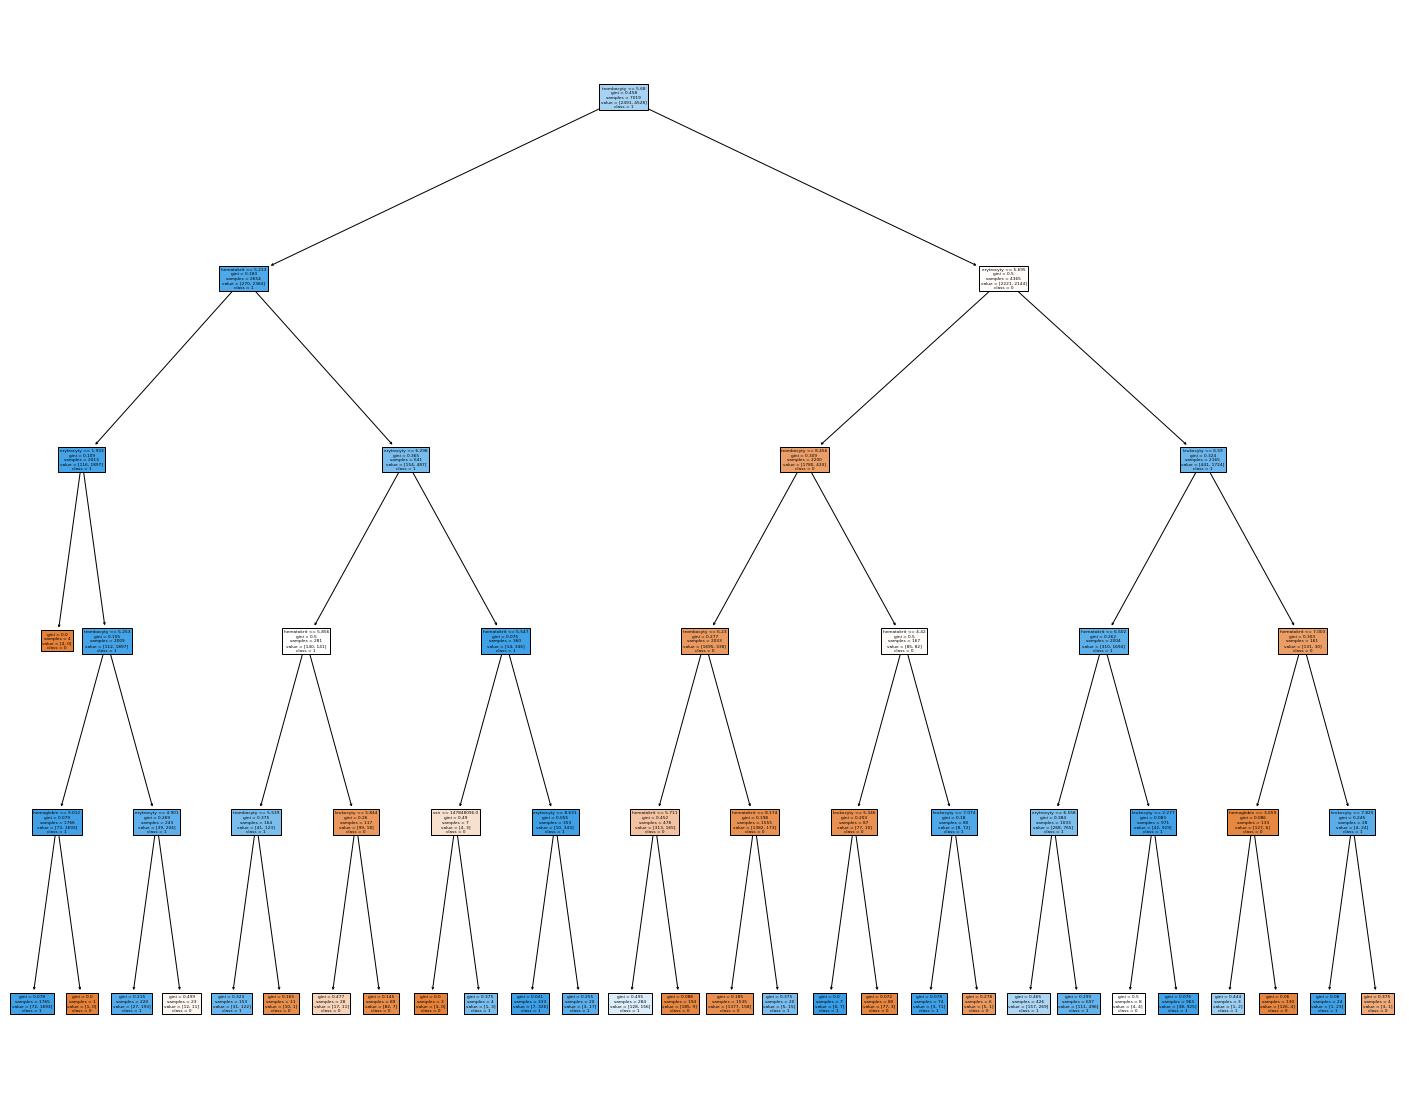

In [20]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(strom,
                   feature_names=x_train.columns,
                   class_names=['0', "1"],
                   filled=True)

[Text(160.57720641268114, 213.41333333333333, 'X[8] <= 5.68\ngini = 0.458\nsamples = 7019\nvalue = [2491, 4528]'),
 Text(69.58119230029492, 205.36, 'X[3] <= 5.213\ngini = 0.183\nsamples = 2654\nvalue = [270, 2384]'),
 Text(44.097042890114125, 197.30666666666667, 'X[6] <= 1.933\ngini = 0.109\nsamples = 2013\nvalue = [116, 1897]'),
 Text(43.410185600718044, 189.25333333333333, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(44.7839001795102, 189.25333333333333, 'X[8] <= 5.253\ngini = 0.105\nsamples = 2009\nvalue = [112, 1897]'),
 Text(21.568928708808823, 181.2, 'X[9] <= 9.012\ngini = 0.079\nsamples = 1766\nvalue = [73, 1693]'),
 Text(20.882071419412746, 173.14666666666668, 'X[8] <= 1.995\ngini = 0.078\nsamples = 1765\nvalue = [72, 1693]'),
 Text(10.866296961148866, 165.09333333333333, 'X[5] <= 7.649\ngini = 0.444\nsamples = 6\nvalue = [2, 4]'),
 Text(10.17943967175279, 157.04, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(11.553154250544942, 157.04, 'gini = 0.0\nsamples = 2\nvalue 

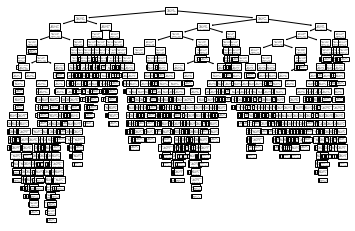

In [21]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

tree.plot_tree(clf) 

In [22]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x_train, y_train, test_size=0.35, train_size=0.65,stratify=y_train) 

#alebo, neviem vyber si

train, test  = train_test_split(df_labor, test_size=0.35, random_state=25)
x_train, y_train = train.loc[:, train.columns != 'indicator'], train['indicator']
x_test, y_test = test.loc[:, test.columns != 'indicator'], test['indicator']
print(len(train), len(test))

print(f"Trenovacia vzorka: {train.shape[0]}")
print(f"Testovacia vzorka: {test.shape[0]}")

6518 3510
Trenovacia vzorka: 6518
Testovacia vzorka: 3510


In [23]:
#po zmeneni pomeru, nove  hodnoty accuracy, precision a recall
forest = RandomForestClassifier(random_state=1)
model = forest.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("Najlepsia accuraccy najdena:")
print(accuracy_score(y_test, y_pred))

print("Najlepsie precision najdene:")
print(precision_score(y_test, y_pred))
#print(precision_score(y_test, y_pred, average='macro'))
#print(precision_score(y_test, y_pred, average='micro'))

print("Najlepsie recall najdene:")
print(recall_score(y_test, y_pred))

#accuracy sa takmer vobec nezmenilo, precision sa o trosku zhorsilo a recall sa o trosku zlepsilo
#celkovy vysledok pri povodne pomere 70:30 bol lepsi

Najlepsia accuraccy najdena:
0.9150997150997151
Najlepsie precision najdene:
0.909556313993174
Najlepsie recall najdene:
0.9612263300270514


In [24]:
# Bod 4
df_labor = pd.read_csv("labor.csv", sep='\t', index_col=0)

del df_labor["name"]
del df_labor["smoker"]
del df_labor["relationship"]
df_labor['ssn'] = df_labor['ssn'].str.replace('-','')

nan_value = float("NaN")

# zmena nahradenie median
for x in df_labor.columns:
    median = df_labor[x].median()
    df_labor[x].fillna(median, inplace = True)

train, test  = train_test_split(df_labor, test_size=0.3, random_state=25)

x_train, y_train = train.loc[:, train.columns != 'indicator'], train['indicator']
x_test, y_test = test.loc[:, test.columns != 'indicator'], test['indicator']
print(len(train), len(test))

print(f"Trenovacia vzorka: {train.shape[0]}")
print(f"Testovacia vzorka: {test.shape[0]}")

7019 3009
Trenovacia vzorka: 7019
Testovacia vzorka: 3009


In [25]:
# Bod 4
# po zmeneni pomeru, nove  hodnoty accuracy, precision a recall
forest = RandomForestClassifier(random_state=1)
model = forest.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("Najlepsia accuraccy najdena:")
print(accuracy_score(y_test, y_pred))

print("Najlepsie precision najdene:")
print(precision_score(y_test, y_pred))

print("Najlepsie recall najdene:")
print(recall_score(y_test, y_pred))

#accuracy sa takmer vobec nezmenilo, precision sa o trosku zhorsilo a recall sa o trosku zlepsilo
#celkovy vysledok pri povodne pomere 70:30 bol lepsi

Najlepsia accuraccy najdena:
0.9149219009637753
Najlepsie precision najdene:
0.9122632103688934
Najlepsie recall najdene:
0.9581151832460733


In [26]:
# Bod 4
df_labor = pd.read_csv("labor.csv", sep='\t', index_col=0)

del df_labor["name"]
del df_labor["smoker"]
del df_labor["relationship"]
df_labor['ssn'] = df_labor['ssn'].str.replace('-','')

nan_value = float("NaN")

# zmena nahradenie median
for x in df_labor.columns:
    median = df_labor[x].median()
    df_labor[x].fillna(median, inplace = True)

# zmena pomeru na 40-60
train, test  = train_test_split(df_labor, test_size=0.4, random_state=25)

x_train, y_train = train.loc[:, train.columns != 'indicator'], train['indicator']
x_test, y_test = test.loc[:, test.columns != 'indicator'], test['indicator']
print(len(train), len(test))

print(f"Trenovacia vzorka: {train.shape[0]}")
print(f"Testovacia vzorka: {test.shape[0]}")

6016 4012
Trenovacia vzorka: 6016
Testovacia vzorka: 4012


In [27]:
#po zmeneni pomeru, nove  hodnoty accuracy, precision a recall
forest = RandomForestClassifier(random_state=1)
model = forest.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("Najlepsia accuraccy najdena:")
print(accuracy_score(y_test, y_pred))

print("Najlepsie precision najdene:")
print(precision_score(y_test, y_pred))

print("Najlepsie recall najdene:")
print(recall_score(y_test, y_pred))

# accuracy sa takmer vobec nezmenilo, precision sa o trosku zhorsilo a recall sa o trosku zlepsilo
# záver - väčšia trénovacia množina odhaduje dáta lepšie

Najlepsia accuraccy najdena:
0.9112662013958126
Najlepsie precision najdene:
0.9061224489795918
Najlepsie recall najdene:
0.9595284872298625


In [50]:
# Bod 4
# Hyper paramater tuning je vykonávaný dostatočne v bode 3 aj s opisom teórie
# Výber atribútov a výber algoritmov
# - vybrali sme si random forest z dôvodu jeho rýchlosti
# Stratégia riešenia chýbajúcich hodnôt:
# - vrámci zadania sme skúšali mean, median a skúšali sme aj zmenu pomeru
#   train a test datasetov, vrámci atribútov dropujeme stále nepodstatné stĺpce
# 
# Ako najlepší ukazateľ zmeny sa ukázalo to, že čím väčšia je trénovaná množina
# tým lepšie vieme určiť presne, či ide o pacienta chorého alebo zdravého.
#
#